为了解决复杂管网的水力学分析问题，我们可以使用Python中的networkx库来构建管网模型，并使用matplotlib库进行绘图。以下是一个简化的示例代码，用于计算环状和支状管网的水头损失。这里我们假设使用达西-韦斯巴赫方程计算水头损失。

为了处理可变流量和节点出水流量（需求的流量）以及恒定水头的情况，我们需要对问题进行更复杂的处理。在下面的代码中，我们将设置每个节点的需求流量，并且设定一个恒定水头。然后，我们将通过迭代方法来计算每个节点的流量分配，直到达到稳定状态。

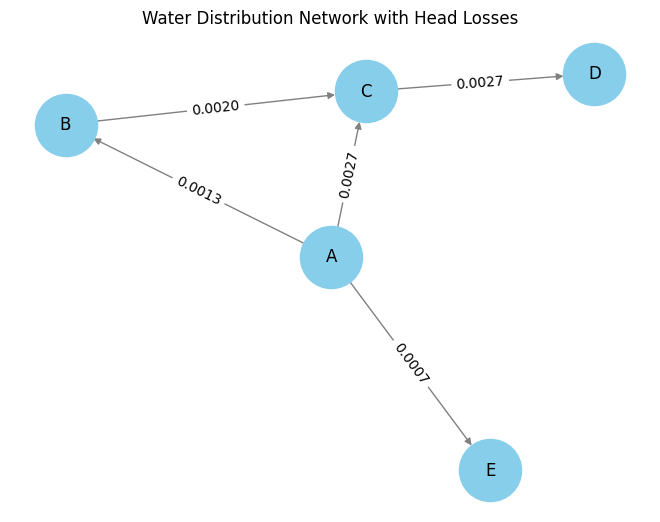

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


# 导入数学库
import math

def calculate_friction_factor(roughness, diameter, reynolds):
    f = 0.01  # 初始猜测值
    error = 1e-6  # 定义误差容忍度
    iterations = 0
    max_iterations = 1000

    # 判断流态
    if reynolds < 2300:  # 层流
        f = 64 / reynolds
    elif reynolds > 4000:  # 湍流
        if roughness == 0:  # 假设光滑管
            f = 0.079 * pow(reynolds, -0.25)
        else:  # 粗糙管
            epsilon_over_d = roughness / diameter
            f = 1 / (2 * math.log10(epsilon_over_d / 3.7 + 2.51 / reynolds)) ** 2

    else:  # 层流与湍流之间的过渡区域
        while iterations < max_iterations:
            f1 = -2 * math.log10((roughness / (3.7 * diameter)) + (2.51 / (reynolds * math.sqrt(f))))
            df = f1 - f
            f = f1

            if abs(df) < error:
                break

            iterations += 1

    return f

# 定义计算水头损失的函数
def darcy_weisbach(Q, D, roughness, L):
    """
    计算水头损失
    :param Q: 流量 (m^3/s)
    :param D: 管径 (m)
    :param roughness: 管道粗糙系数
    :param L: 管道长度 (m)
    :return: 水头损失 (m)
    """
    v = Q / (np.pi * (D/2)**2)  # 计算流速
    Re = (v * D) / 0.000001  # 计算雷诺数，假设运动粘度为0.000001 m^2/s
    # f = 0.316 / Re**0.25 if Re < 2000 else 0.316 / Re**0.25  # 计算摩擦因子
    f=calculate_friction_factor(roughness,D,Re)

    h_loss = f * (L / D) * (v**2 / (2 * 9.81))  # 计算水头损失
    return h_loss

# 定义计算水头损失的函数 roughness
def calculate_head_loss(flow, diameter, length, friction_factor):
    # 如果没有提供摩擦因子，则使用达西-韦斯巴赫公式估计
    if friction_factor is None:
        reynolds = (flow * diameter) / (np.pi * (diameter / 2)**2)
        friction_factor = 0.3164 / reynolds**0.25  # 使用简化的公式
    
    # 计算水头损失
    head_loss = friction_factor * (length / diameter) * (flow**2 / (2 * 9.81))
    return head_loss

# 创建管网图
G = nx.DiGraph()

# 添加节点和边，以及它们的属性
# 示例属性，需要根据实际管网修改
nodes = ['A', 'B', 'C', 'D', 'E']
G.add_nodes_from(nodes)
G.add_edge('A', 'B', length=100, diameter=0.2, roughness=0.005)
G.add_edge('B', 'C', length=150, diameter=0.2, roughness=0.005)
G.add_edge('C', 'D', length=200, diameter=0.2, roughness=0.005)
G.add_edge('A', 'C', length=200, diameter=0.2, roughness=0.005)
G.add_edge('A', 'E', length=50, diameter=0.2, roughness=0.005)

# 假设每个节点的流量需求
node_demands = {'B': -0.01, 'C': -0.02}  # 流出为负

# 初始化流量
flow_init = 1* (np.pi * (0.2/2)**2)  

flows = dict.fromkeys(G.edges(), flow_init) #0.1)  # 假设初始流量为0.01 m^3/s

# 计算每个管段的水头损失
for edge in G.edges():
    flow = flows[edge]
    length = G.edges[edge]['length']
    diameter = G.edges[edge]['diameter']
    roughness = G.edges[edge]['roughness']
    v = flow / (np.pi * (diameter/2)**2)  # 计算流速
    Re = (v * diameter) / 0.000001  # 计算雷诺数，假设运动粘度为0.000001 m^2/s
    friction_factor=calculate_friction_factor(roughness,diameter,reynolds=Re)

    head_loss = calculate_head_loss(flow, diameter,  length,friction_factor)
    G.edges[edge]['head_loss'] = head_loss

# 绘制管网图
pos = nx.spring_layout(G)  # 节点的布局
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray')

# 在管段上标注水头损失
# labels = nx.get_edge_attributes(G, 'head_loss')
# 在管段上标注水头损失，仅显示小数点后三位
labels = nx.get_edge_attributes(G, 'head_loss')
formatted_labels = {k: f"{v:.4f}" for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels)

# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title('Water Distribution Network with Head Losses')
plt.show()


这段代码首先定义了一个计算水头损失的函数，然后创建了一个管网图，并为每个管段计算了水头损失。最后，使用matplotlib绘制了管网图，并在管段上标注了水头损失。

请注意，这只是一个示例，实际应用中可能需要考虑更多的因素，如管网的实际布局、管段的具体参数、流量分配等。此外，对于复杂管网，可能需要使用更高级的水力学模型和求解方法。